In [61]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from string import digits
import numpy as np 
import pandas as pd
from PIL import Image
import pickle

In [62]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Import Data
Get dataset and split into individual sentences

Create word corpus (vocabulary list from dataset)

Calculate total number of unique words, +1 for the padding "words"

In [63]:
with open('data/captions.txt') as f:
    captions = [lines.strip().split(',') for lines in f.readlines()]

captions = captions[1:]
f.close()

In [64]:
captions = pd.DataFrame(captions)
captions.head(1)

,0,1,2,3,4,5,6
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,None,None,None,None,None


In [65]:
captions.describe()

,0,1,2,3,4,5,6
count,40455,40455,2447,715,64,5,1
unique,8091,39929,2288,705,64,5,1
top,3249597269_935e0a375a.jpg,"""Two dogs","""","and a backpack .""",sitting,and red,are waving to the crowd along the parade rout...
freq,5,37,19,3,1,1,1


## Data Cleansing For The Captions

In [66]:
idx_lines_split = []
for i in [2,3,4,5,6]:
    idx_lines_split += list(captions[captions[i].notnull()].index)

idx_lines_split = list(set(idx_lines_split))

remove_digits = str.maketrans('', '', digits)
for index in idx_lines_split:
    # merging the sentences that were split into multiple columns into a string
    merged_caption = " ".join(captions.iloc[index,[1,2,3,4,5,6]].fillna("").values).strip()
    captions.iloc[index,1] = merged_caption

cleaned_captions = []
for i in range(len(captions)):
    # removing numbers from the string
    cleaned_caption = captions.iloc[i,1].translate(remove_digits)
    cleaned_captions.append(cleaned_caption)

In [75]:
# with open("data/cleaned_captions.pickle", 'wb') as file_pi:
#     pickle.dump(cleaned_captions, file_pi)

with open("data/cleaned_captions.pickle", "rb") as f:
    cleaned_captions = pickle.load(f)

In [ ]:
# every 5 rows, extract the image linked to those 5 captions
for i in range(0,len(captions),5):
    filename = captions.iloc[i,0]
    img = Image.open("data/Images/" + captions.iloc[i,0])

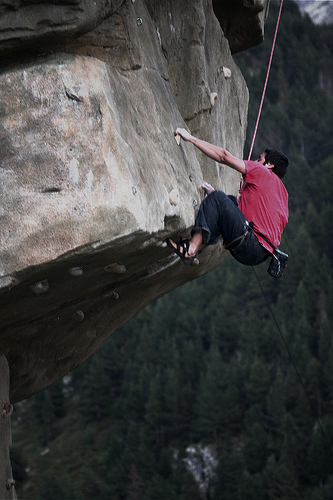

In [83]:
Image.fromarray(np.array(img))

In [ ]:
corpus = data.lower().split("\n")

tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

In [ ]:
input_sequences = []
for line in corpus: # for each sentence in dataset
	token_list = tokenizer.texts_to_sequences([line])[0] # tokenize each sentence
	for i in range(1, len(token_list)): # create n-grams for each sentence so that
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences so that inputs will have same length
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label (last word in sentence)
sequence, labels = input_sequences[:,:-1],input_sequences[:,-1]

labels = tf.keras.utils.to_categorical(labels, num_classes=total_words) #convert them to categorical and one hot encode them so that it can predict which word from the vocab it is

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(sequence, labels, epochs=100, verbose=1)
#print model.summary()
print(model)

In [ ]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

stuff

In [ ]:
    def get_discriminator(self):
        image_input = Input(shape=self.image_size)

        x = self.conv_block(image_input, 128, 4, 2, 'same', use_batch_norm=True, use_bias=False, activation=LeakyReLU(alpha=leaky_relu_slope))
        x = self.conv_block(x, 128, 4, 2, 'same', use_batch_norm=True, use_bias=False, activation=LeakyReLU(alpha=leaky_relu_slope))
        x = self.conv_block(x, 128, 4, 2, 'same', use_batch_norm=True, use_bias=False, activation=LeakyReLU(alpha=leaky_relu_slope))

        x = Flatten()(x)
        x = Dropout(0.4)(x)
        output_score = Dense(1)(x)

        return keras.Model(image_input, output_score, name="discriminator")